## **Section 1: Imports**

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 6)

## **Section 2: Functions**

In [ ]:
# Feature Engineering
def feature_engineering(sales_data, lag_range=12):
    # Converting 'date' to datetime and creating 'year_month'
    sales_data['date'] = pd.to_datetime(sales_data['date'])
    sales_data['year_month'] = sales_data['date'].dt.to_period('M')

    # Aggregating sales data monthly
    monthly_aggregated_data = sales_data.groupby(['year_month', 'item'])['sales'].agg(total_sales=('sum')).reset_index()

    # Calculating the difference for 'total_sales'
    monthly_aggregated_data['total_sales_diff'] = monthly_aggregated_data.groupby('item')['total_sales'].diff()
    monthly_aggregated_data.set_index('year_month', inplace=True)
    monthly_aggregated_data.dropna(inplace=True)

    # Creating lagged columns for 'total_sales_diff'
    for lag in range(1, lag_range + 1):
      monthly_aggregated_data[f'total_sales_diff_lag_{lag}'] = monthly_aggregated_data.groupby('item')['total_sales_diff'].shift(lag)

    # Drop rows with NaN values
    monthly_aggregated_data = monthly_aggregated_data.dropna()

    return monthly_aggregated_data

In [ ]:
# Splitting dataset in train data and test data
def split_data(data, feature_columns, target_column, test_size=0.2, random_state=42, shuffle=False):

    train_data, test_data = train_test_split(monthly_aggregated_data, test_size=test_size, random_state=random_state, shuffle=shuffle)

    X_train, y_train = train_data[feature_columns], train_data[target_column]
    X_test, y_test = test_data[feature_columns], test_data[target_column]

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
# Model training
def train_regressor_model(regressor, X_train, y_train, hyperparameters=None, random_state=42):

  regressor.set_params(random_state=random_state)
  if hyperparameters:
      model = regressor.set_params(**hyperparameters)
  else:
      model = regressor

  model.fit(X_train, y_train)
  return model

In [ ]:
# Tuning the data model
def tune_it(estimator, X_train, y_train, param_grid, random_state=42, scoring='neg_mean_absolute_error', n_splits=3, verbose=2, n_jobs=-1):

    estimator.set_params(random_state=random_state)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    grid_search = GridSearchCV(estimator, param_grid=param_grid, scoring=scoring, cv=tscv, verbose=verbose, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_


In [ ]:
# Evaluating the model
def evaluate_model(model, X_test_scaled, y_test):
    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Calculating regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = (2 * np.mean(np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test)))) * 100
    r2 = r2_score(y_test, y_pred)

    results = {
        'y_test_pred': y_pred.tolist(),
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'smape': smape,
        'r2': r2
    }

    return results


In [ ]:
# Inverse transformed data and Reverting the differences to forecasted total sales
def inverse_transform_and_revert_differencing(y_pred, train_data, test_data, scaler):
    y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
    # Obtaining forecasted total sales
    last_total_sales_per_item = train_data.groupby('item')['total_sales'].last().to_dict()
    forecasted_total_sales = y_pred.copy()

    for item in last_total_sales_per_item:
      item_indices = test_data['item'] == item
      forecasted_total_sales[item_indices] += last_total_sales_per_item[item]

    return forecasted_total_sales

In [ ]:
# Print evaluation results
def print_evaluation_results(model_name, results):

    print(f"{model_name} Evaluation on Test Set:")
    print(f'Mean Absolute Error (MAE): {results.get("mae", "N/A")}')
    print(f'Mean Squared Error (MSE): {results.get("mse", "N/A")}')
    print(f'Root Mean Squared Error (RMSE): {results.get("rmse", "N/A")}')
    print(f'Mean Absolute Percentage Error (MAPE): {results.get("mape", "N/A")}%')
    print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {results.get("smape", "N/A")}%')
    print(f'Coefficient of determination (R²): {results.get("r2", "N/A")}')


In [ ]:
# Plotting the actual and forecasted monthly total sales
def plot_it(data, predictions, title='Actual and Forecasted Monthly Item Demand on Test Set'):

  plt.plot(data['total_sales'].values, label='Actual Monthly Item Demand (Test Set)')
  plt.plot(forecasted_total_sales_xgb, label='Forecasted  Monthly Item Demand', color='orange')

  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
# Create metrics dataframe
def create_metrics_dataframe(results_dict, model_name):
    metrics_data = {
        'Model': [model_name],
        'MAE': [results_dict.get('mae', 'N/A')],
        'MSE': [results_dict.get('mse', 'N/A')],
        'RMSE': [results_dict.get('rmse', 'N/A')],
        'MAPE': [results_dict.get('mape', 'N/A')],
        'SMAPE': [results_dict.get('smape', 'N/A')],
        'R²': [results_dict.get('r2', 'N/A')]
    }

    df = pd.DataFrame(metrics_data)
    return df

In [ ]:
# Future forecasting - next month
def predict_next_month(model,  data, items_to_forecast, scaler_x, scaler_y, lag_range_training=12):
  temp_df = data.drop(columns=['total_sales', 'total_sales_diff'], axis=1).reset_index().copy()
  items_to_forecast = items_to_forecast
  lag_range_training = lag_range_training
  lag_features_used = [f'total_sales_diff_lag_{lag}' for lag in range(1, lag_range_training + 1)]

  lagged_data_per_item = pd.DataFrame()
  for item in items_to_forecast:
    lagged_data_item = temp_df[temp_df['item'] == item].tail(lag_range_training)
    lagged_data_item['item'] = item
    lagged_data_item = [ value for  _, value in lagged_data_item.iterrows() if str(value['year_month'])== '2017-12'][0].to_dict()
    lagged_data_item = pd.DataFrame([lagged_data_item])
    lagged_data_per_item= pd.concat([lagged_data_per_item, lagged_data_item], ignore_index=True)


  X_future_scaled = scaler_x.transform(lagged_data_per_item.drop(['year_month'], axis=1))

  y_future_pred = model.predict(X_future_scaled)
  y_future_pred = scaler_y.inverse_transform(y_future_pred.reshape(-1,1)).ravel()

  last_total_sales_per_item = data.groupby('item')['total_sales'].last().to_dict()
  preds = y_future_pred.copy()

  last_total_sales_per_item = np.array(list(last_total_sales_per_item.values()))
  preds += last_total_sales_per_item

  return {index: "{:.2f}".format(pred) for index, pred in enumerate(preds, start=1)}

## **Section 3: Execution**

In [ ]:
# Load dataset
sales_data = pd.read_csv(data_path, index_col=None)

# Aggregate data
monthly_aggregated_data = feature_engineering(sales_data)

# Split data
feature_columns = ['item'] + [f'total_sales_diff_lag_{lag}' for lag in range(1, 13)]
target_column = ['total_sales_diff']
train_data, test_data, X_train, X_test, y_train, y_test = split_data(monthly_aggregated_data, feature_columns, target_column)

# Scale data
scaler_x = MinMaxScaler(feature_range=(-1,1))
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y =  MinMaxScaler(feature_range=(-1,1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [ ]:
# Find best hyperparameters --> XGB
param_girds_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha': [0, 0.1, 0.5]
}
best_params_xgb = tune_it(XGBRegressor(), X_train_scaled, y_train, param_girds_xgb)

In [ ]:
best_params_xgb

{'colsample_bytree': 1.0,
 'gamma': 0.1,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 100,
 'reg_alpha': 0.5,
 'reg_lambda': 1,
 'subsample': 0.8}

In [ ]:
# Find best hyperparameters --> RF
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
best_params_rf = tune_it(RandomForestRegressor(), X_train_scaled, y_train.values.ravel(), param_grid_rf)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [ ]:
best_params_rf

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
# Train and Evaluate ---> XGBRegressor
model_xgb = train_regressor_model(XGBRegressor(), X_train_scaled, y_train_scaled, hyperparameters=best_params_xgb)

results_xgb =  evaluate_model(model_xgb, X_test_scaled, y_test_scaled)

forecasted_total_sales_xgb = inverse_transform_and_revert_differencing(np.array(results_xgb['y_test_pred']),
                                                                       train_data,
                                                                       test_data,
                                                                       scaler_y)


In [ ]:
print_evaluation_results("XGB", results_xgb)

XGB Evaluation on Test Set:
Mean Absolute Error (MAE): 0.048378673434081566
Mean Squared Error (MSE): 0.0038588328156998063
Root Mean Squared Error (RMSE): 0.062119504309836586
Mean Absolute Percentage Error (MAPE): 403.31989690751254%
Symmetric Mean Absolute Percentage Error (SMAPE): 136.32992417853197%
Coefficient of determination (R²): 0.9690382828124866


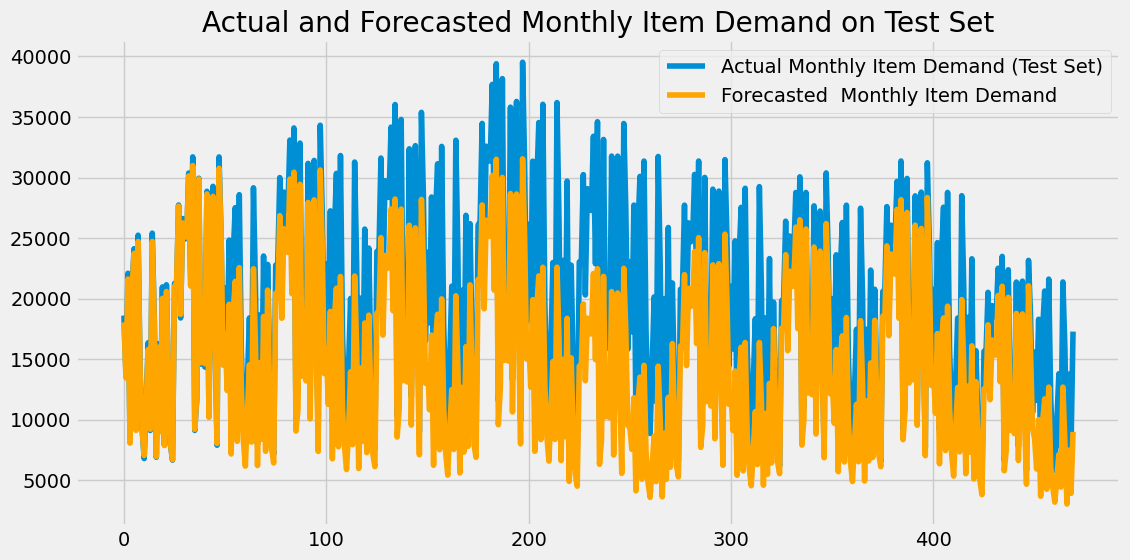

In [ ]:
plot_it(test_data, forecasted_total_sales_xgb)

In [ ]:
# Train and Evaluate ---> RandomForestRegressor
model_rf = train_regressor_model(RandomForestRegressor(),  X_train_scaled, y_train_scaled.ravel(), hyperparameters=best_params_rf)

results_rf =  evaluate_model(model_rf, X_test_scaled, y_test_scaled)

forecasted_total_sales_rf = inverse_transform_and_revert_differencing(np.array(results_xgb['y_test_pred']),
                                                                       train_data,
                                                                       test_data,
                                                                      scaler_y)

In [ ]:
print_evaluation_results('RF', results_rf)

RF Evaluation on Test Set:
Mean Absolute Error (MAE): 0.04335593751132696
Mean Squared Error (MSE): 0.00335075790994151
Root Mean Squared Error (RMSE): 0.05788573148835134
Mean Absolute Percentage Error (MAPE): 418.7371680214078%
Symmetric Mean Absolute Percentage Error (SMAPE): 135.61807057399358%
Coefficient of determination (R²): 0.9731148708103287


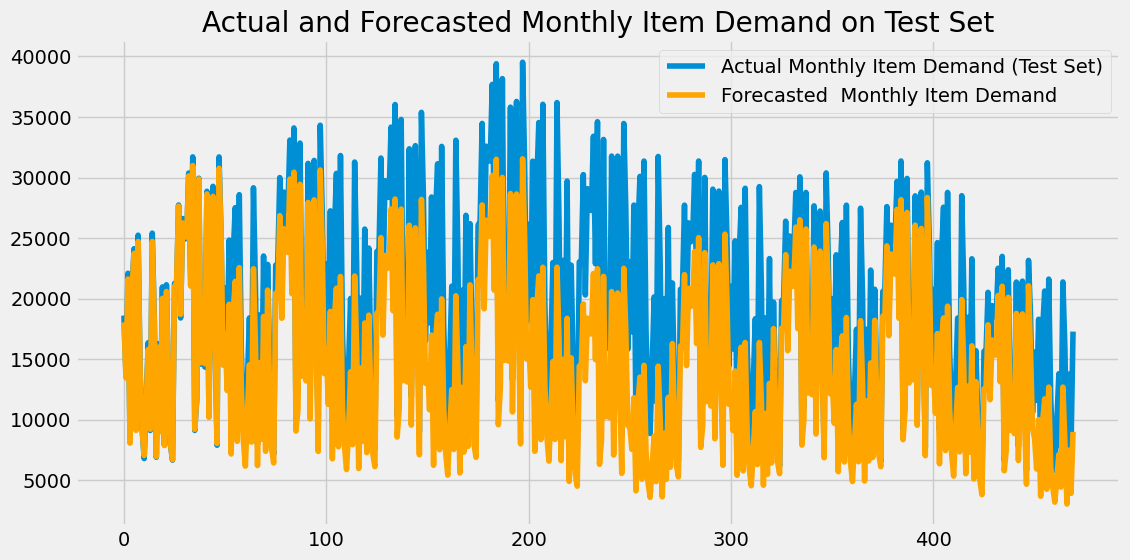

In [ ]:
plot_it(test_data, forecasted_total_sales_rf)

In [ ]:
# Metrics dataframe
df_xgb = create_metrics_dataframe(results_xgb, 'XGB')
df_rf = create_metrics_dataframe(results_rf, 'RF')
df_metrics = pd.concat([df_xgb, df_rf], ignore_index=True)
df_colored = df_metrics.style.applymap(lambda val: 'background-color: lightcoral' if isinstance(val, (int, float)) and val <= np.min([x for x in df_metrics.values.flatten() if isinstance(x, (int, float))]) else '')
df_colored

,Model,MAE,MSE,RMSE,MAPE,SMAPE,R²
0,XGB,0.048379,0.003859,0.062120,403.319897,136.329924,0.969038
1,RF,0.043356,0.003351,0.057886,418.737168,135.618071,0.973115


In [ ]:
# Items Demand Forecasting for next month after the last date - XGB
items_to_forecast = [i for i in range(1, 51)]
predict_next_month(model_xgb, monthly_aggregated_data, items_to_forecast, scaler_x, scaler_y, lag_range_training=12)

{1: '4170.79',
 2: '10556.84',
 3: '6709.19',
 4: '3932.47',
 5: '3096.24',
 6: '9874.48',
 7: '9754.09',
 8: '13999.60',
 9: '8752.61',
 10: '12906.60',
 11: '12420.60',
 12: '12060.08',
 13: '15993.60',
 14: '10576.84',
 15: '16971.60',
 16: '4200.96',
 17: '5736.92',
 18: '15863.60',
 19: '7051.93',
 20: '8189.83',
 21: '6816.06',
 22: '14851.60',
 23: '5223.24',
 24: '11178.08',
 25: '14925.60',
 26: '7819.61',
 27: '3596.51',
 28: '16641.60',
 29: '12070.60',
 30: '7201.35',
 31: '10008.29',
 32: '7157.93',
 33: '11778.60',
 34: '4584.30',
 35: '11490.81',
 36: '14107.60',
 37: '5091.10',
 38: '15092.60',
 39: '7160.93',
 40: '5302.66',
 41: '3803.33',
 42: '6149.77',
 43: '8845.66',
 44: '5220.24',
 45: '14859.60',
 46: '10001.48',
 47: '3712.51',
 48: '8988.61',
 49: '4563.01',
 50: '10758.60'}

In [ ]:
# Items Demand Forecasting for next month after the last date - RF
items_to_forecast = [i for i in range(1, 51)]
predict_next_month(model_rf, monthly_aggregated_data, items_to_forecast, scaler_x, scaler_y, lag_range_training=12)

{1: '3957.58',
 2: '10651.98',
 3: '6379.44',
 4: '3817.08',
 5: '3109.13',
 6: '9873.16',
 7: '10039.83',
 8: '13244.12',
 9: '8529.49',
 10: '12408.94',
 11: '11959.89',
 12: '11711.89',
 13: '15077.59',
 14: '10611.79',
 15: '15994.01',
 16: '4272.43',
 17: '5593.82',
 18: '14962.58',
 19: '6915.56',
 20: '8166.23',
 21: '6801.75',
 22: '14161.78',
 23: '5123.96',
 24: '11282.45',
 25: '14038.45',
 26: '7821.95',
 27: '3648.95',
 28: '15707.02',
 29: '11795.45',
 30: '7083.08',
 31: '9713.47',
 32: '7374.88',
 33: '11296.57',
 34: '4556.24',
 35: '11484.58',
 36: '13411.64',
 37: '5172.31',
 38: '14461.06',
 39: '7190.29',
 40: '4986.39',
 41: '3672.93',
 42: '5992.83',
 43: '8744.04',
 44: '5211.68',
 45: '14175.41',
 46: '10017.02',
 47: '3818.34',
 48: '8695.79',
 49: '4562.20',
 50: '10477.08'}